In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import json

if not os.path.exists(os.path.join(os.getcwd(), 'config.json')):
  # preventing to go always to the parent folder everytime we run the jupyter notebook without restarting
  os.chdir("..")
if not os.getcwd() in sys.path:
  sys.path.append(os.getcwd())

from analysis.analysis_commons import *
from strategies import *

# Main config
main_config = None
with open('config.json') as config_file:
  main_config = json.load(config_file)

runs = 1 

delayed_response_steps = 20 

selected_topics = [] 
with open('data/contrasting_arguments_labeled_stats_selected.csv', 'r') as f:
  reader = csv.DictReader(f)
  for r in reader:
    if int(r['Selected']) != 1:
      continue
    selected_topics.append(r['Mitigator'] + ' vs ' + r['Disinformer'])
print("Selected topics:", selected_topics)

f = open('data/datavoids_per_topic_filtered.json', 'r')
datavoids_per_topic = json.load(f)
check_repeated_keys(datavoids_per_topic)

to_ignore = [
  # 'Declarative Language vs Procedural Language',
  # 'Optimism vs Pessimism',
  # 'Rationalism vs Empiricism',
  # 'Consumerism vs Minimalism',
  # 'Classical Economics vs Keynesian Economics',
  # 'Individualism vs Collectivism',
  # 'Direct Democracy vs Representative Democracy',
  # 'Bayesian Statistics vs Frequentist Statistics'
]

outputs = {}

for topic in datavoids_per_topic.keys():
  print("Topic:", topic)
  if topic not in selected_topics:
    continue

  if topic in to_ignore:
    continue

  topic_parts = topic.split(' vs ')
  print(topic_parts)

  mitigator_id = datavoids_per_topic[topic]['mitigator_id']
  disinformer_id = datavoids_per_topic[topic]['disinformer_id']
  mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
  disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
  datavoids = datavoids_per_topic[topic]['datavoids']

  main_config['datavoids'] = [datavoids]
  print("Datavoids:", main_config['datavoids'])
  keyword = main_config["datavoids"][0]
  if isinstance(keyword, list):
    keyword = "|".join(keyword)
  
  for flipped in [False, True]:
    print("Flipped: ", flipped)

    if flipped:
      config = clone_config_with_target(main_config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
      config['topic_name'] = topic_parts[0] + ' vs ' + topic_parts[1]
      print("Mitigator:", config["target_groups"][0])
      print("Disinformer:", config["target_groups"][1])
    else:
      config = clone_config_with_target(main_config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
      config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
      print("Mitigator:", config["target_groups"][0])
      print("Disinformer:", config["target_groups"][1])

    groups_count = prepare_db(config, force_preparation=True)
    max_steps = min([c for _, c in groups_count.items()])
    print("Groups count", groups_count, "Max steps", max_steps)
    step_increment = max(1, max_steps // delayed_response_steps)

    steps_delay = step_increment 
    delayed_response_step = 0
    while steps_delay < max_steps:
      print('Delayed response step', delayed_response_step)
      print('Steps delay', steps_delay)

      group = config['mitigator_keyword']
      opponent_group = config['disinformer_keyword']
      def stop_if_greater(agent): 
        _, wavgrank_val = top_k_group_analysis(agent.graph, config)
        our_val = wavgrank_val[group]
        other_val = wavgrank_val[opponent_group]
        if our_val > other_val:
          return True
        return False

      def stop_after_delay(agent):
        return agent.steps_count > steps_delay

      disinformer_strategy = ConditionalEndStrategy(
        RandomStrategy(), 
        stop_after_delay
      )
      mitigator_strategy = DelayedStartStrategy(
        ConditionalEndStrategy(
          OptimalCostsStrategy(),
          lambda agent: stop_if_greater(agent) or stop_after_delay(agent)
        ), 
        steps_delay)

      outputs["delayed" + str(steps_delay) + "-" + config['topic_name']] = {
        "filename": run_simple_simulation(
              keyword, 
              mitigator_strategy, 
              disinformer_strategy, 
              'delayed_responses_step' + str(steps_delay), 
              config,
              mute_output=True,
              number_of_runs=runs,
              delete_results_if_exist=True,
              delete_pagerank=False
          ),
        "delay": steps_delay,
        "delay_step": delayed_response_step,
        "mit": config["target_groups"][0],
        "dis": config["target_groups"][1]
      }

      steps_delay += step_increment
      delayed_response_step += 1


Selected topics: ['Declarative Language vs Procedural Language', 'Optimism vs Pessimism', 'Rationalism vs Empiricism', 'Classical Economics vs Keynesian Economics']
Topic: Declarative Language vs Procedural Language
['Declarative Language', 'Procedural Language']
Datavoids: [['lisp', 'semantics', 'javascript', 'xml', 'syntaxhighlight', 'runtime', 'syntax', 'implementations', 'compiler', 'imperative']]
Flipped:  False
Mitigator: dec
Disinformer: pro
Labeling started
Labeling dec / pro
 Target nodes: 210648 23801
Groups count:
  dec: 51
  pro: 51
  dec|pro: 8
Groups count:
  dec: 39
  pro: 32
Done
Creating important pages
Important pages: 71
Dumping important pages
Dumping idf table
Creating important edges
Important edges: 187
Dumping important edges
Connecting to lite DB
Dropping old tables
Importing important pages and edges
Importing idf
Deleting edges and nodes tables, emptying rank
Creating nodes
Creating edges
Counting
Nodes: 65537
Edges: 335
Done
Labeling started
Labeling dec / p

In [89]:
results_per_delay = {}
config = None

for output in outputs.values():

  for topic in datavoids_per_topic.keys():
    mitigator_id = datavoids_per_topic[topic]['mitigator_id']
    disinformer_id = datavoids_per_topic[topic]['disinformer_id']
    mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
    disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
    if mitigator_label == output['mit'] and disinformer_label == output['dis']:
      config = clone_config_with_target(main_config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
      config['topic_name'] = topic_parts[0] + ' vs ' + topic_parts[1]
    elif mitigator_label == output['dis'] and disinformer_label == output['mit']:
      config = clone_config_with_target(main_config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
      config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
    else:
      continue

    config["output_filename"] = output["filename"]
    steps_per_strategy, strategies, id_max_rank = get_output(config)
    steps_no = max(steps_per_strategy[strategies[0]].keys())
    areas = calculate_area_for_steps_per_strategy(strategies[0], steps_per_strategy, config)
    delay_step = output["delay_step"]

    if topic not in results_per_delay:
      results_per_delay[topic] = {} 
    
    if delay_step not in results_per_delay[topic]:
      results_per_delay[topic][delay_step] = {
        'mit': [],
        'dis': []
      }

    last_step = max(list(steps_per_strategy[strategies[0]].keys()))
    cost_dis_vals = steps_per_strategy[strategies[0]][last_step][output['dis']]["cost"]
    results_per_delay[topic][delay_step]['dis'].append(sum(cost_dis_vals) / len(cost_dis_vals))
    cost_mit_vals = steps_per_strategy[strategies[0]][last_step][output['mit']]["cost"]
    results_per_delay[topic][delay_step]['mit'].append(min(cost_mit_vals))

  # plot_results_for_steps_per_strategy(
  #   strategies[0], 
  #   steps_per_strategy,
  #   config,
  #   # max_x=max_steps
  # )

  # plot_costs(
  #   strategies[0], 
  #   steps_per_strategy, 
  #   config,
  #   filter_groups=['None'],
  #   steps_no=steps_no,
  #   max_x=max_steps
  # )

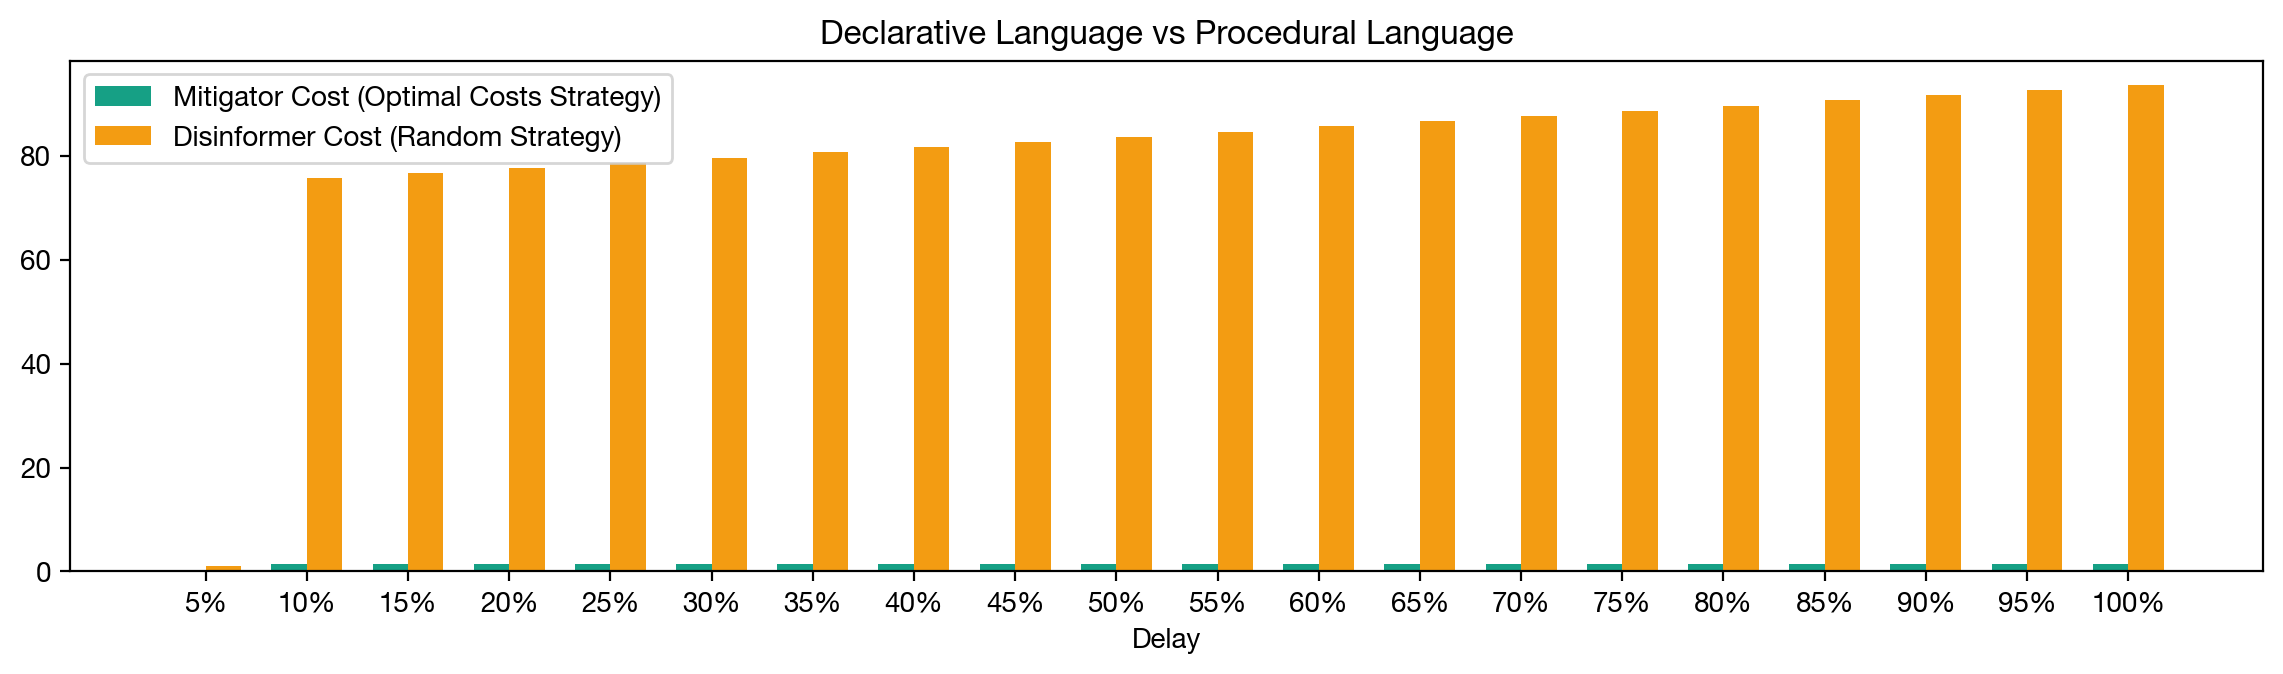

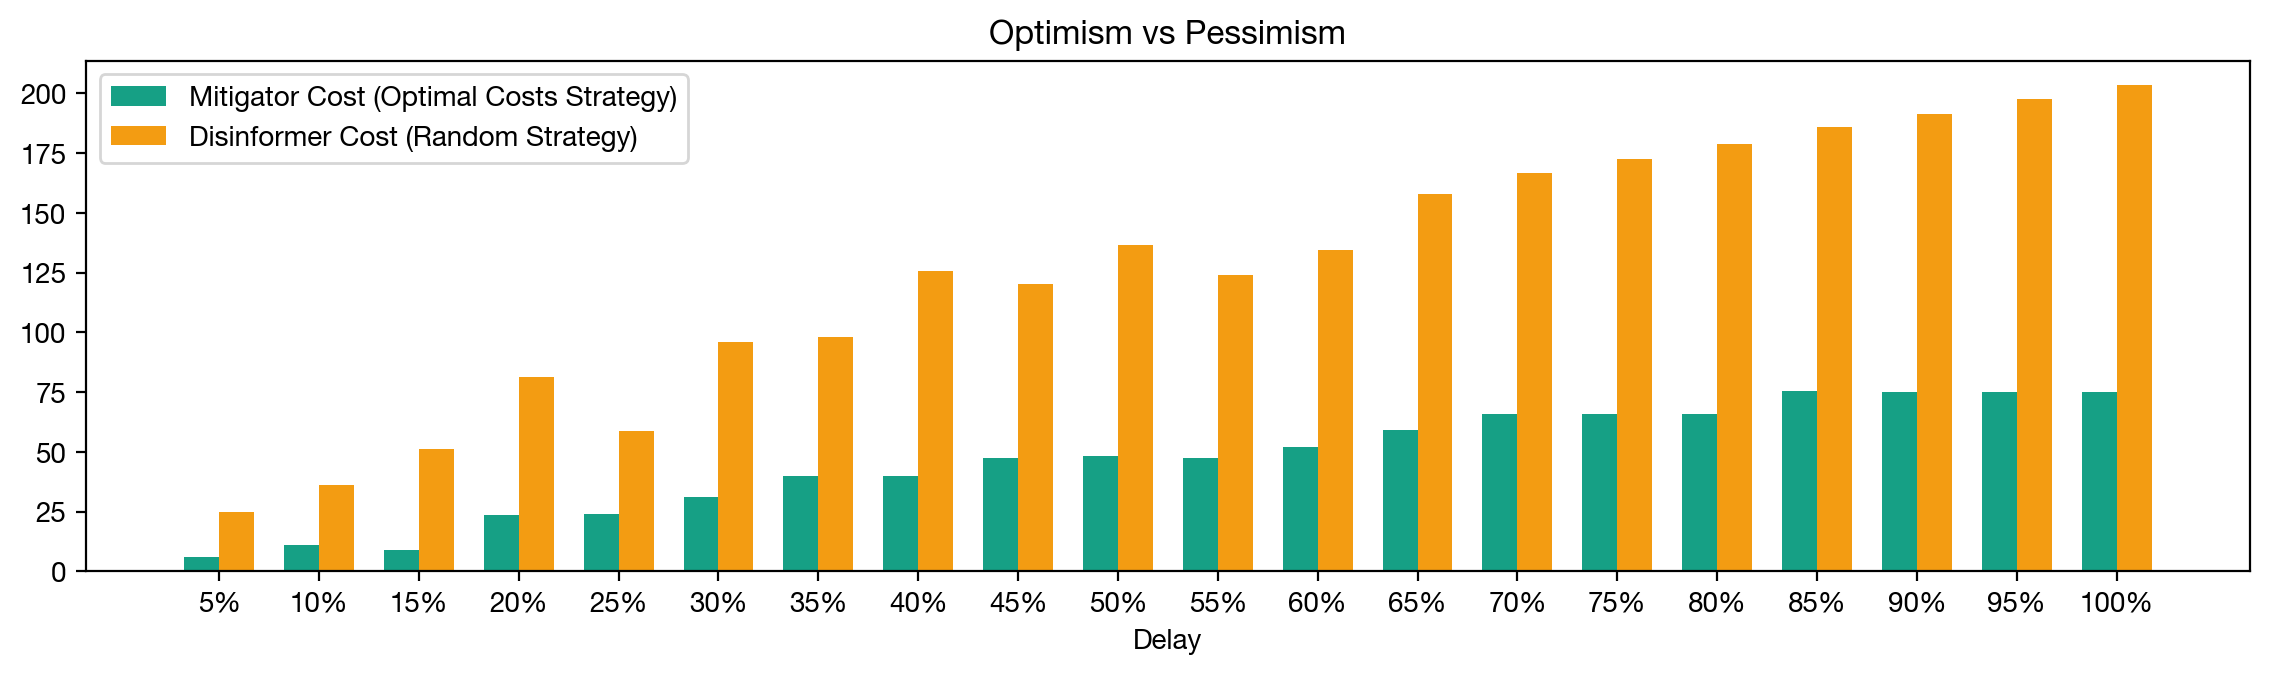

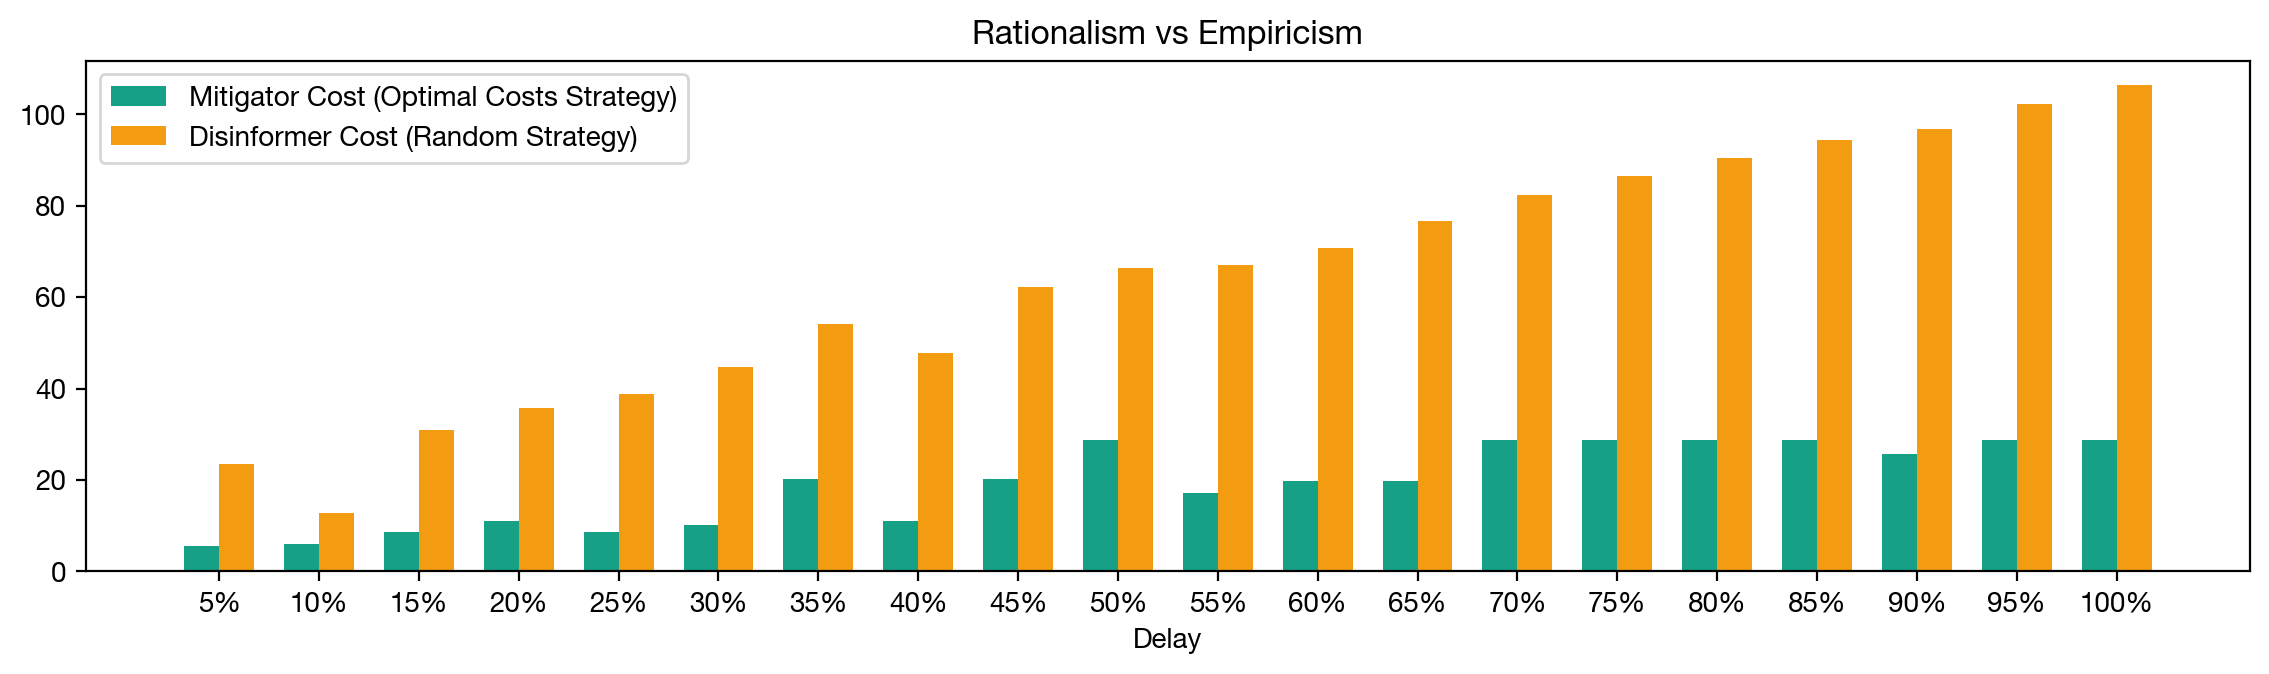

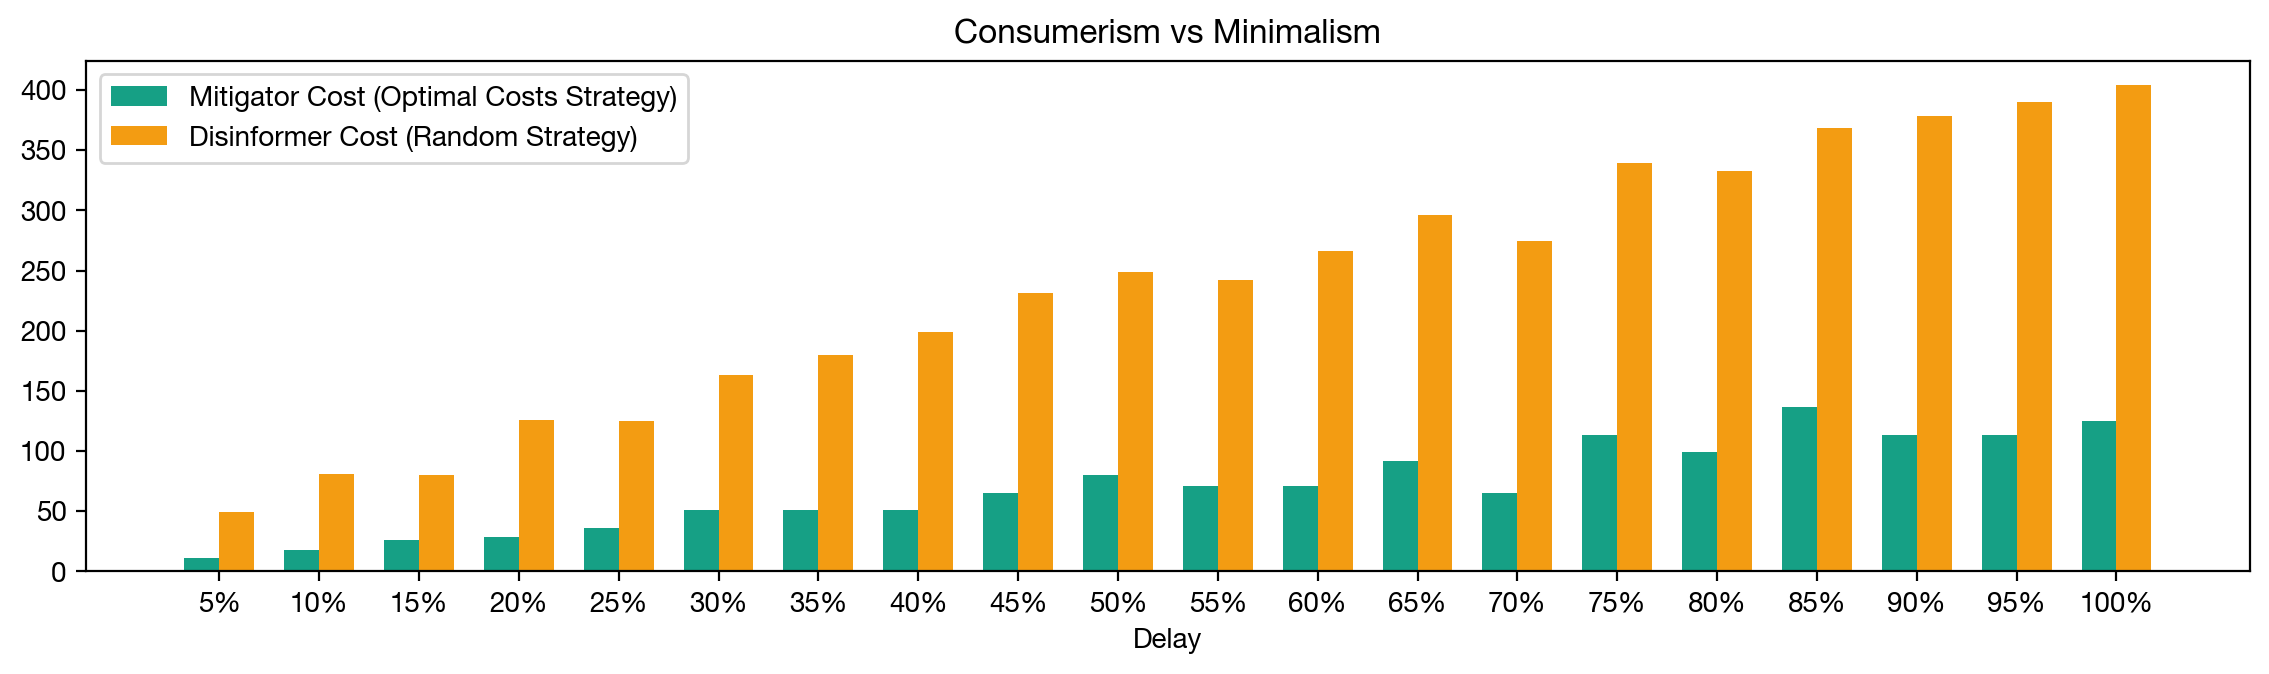

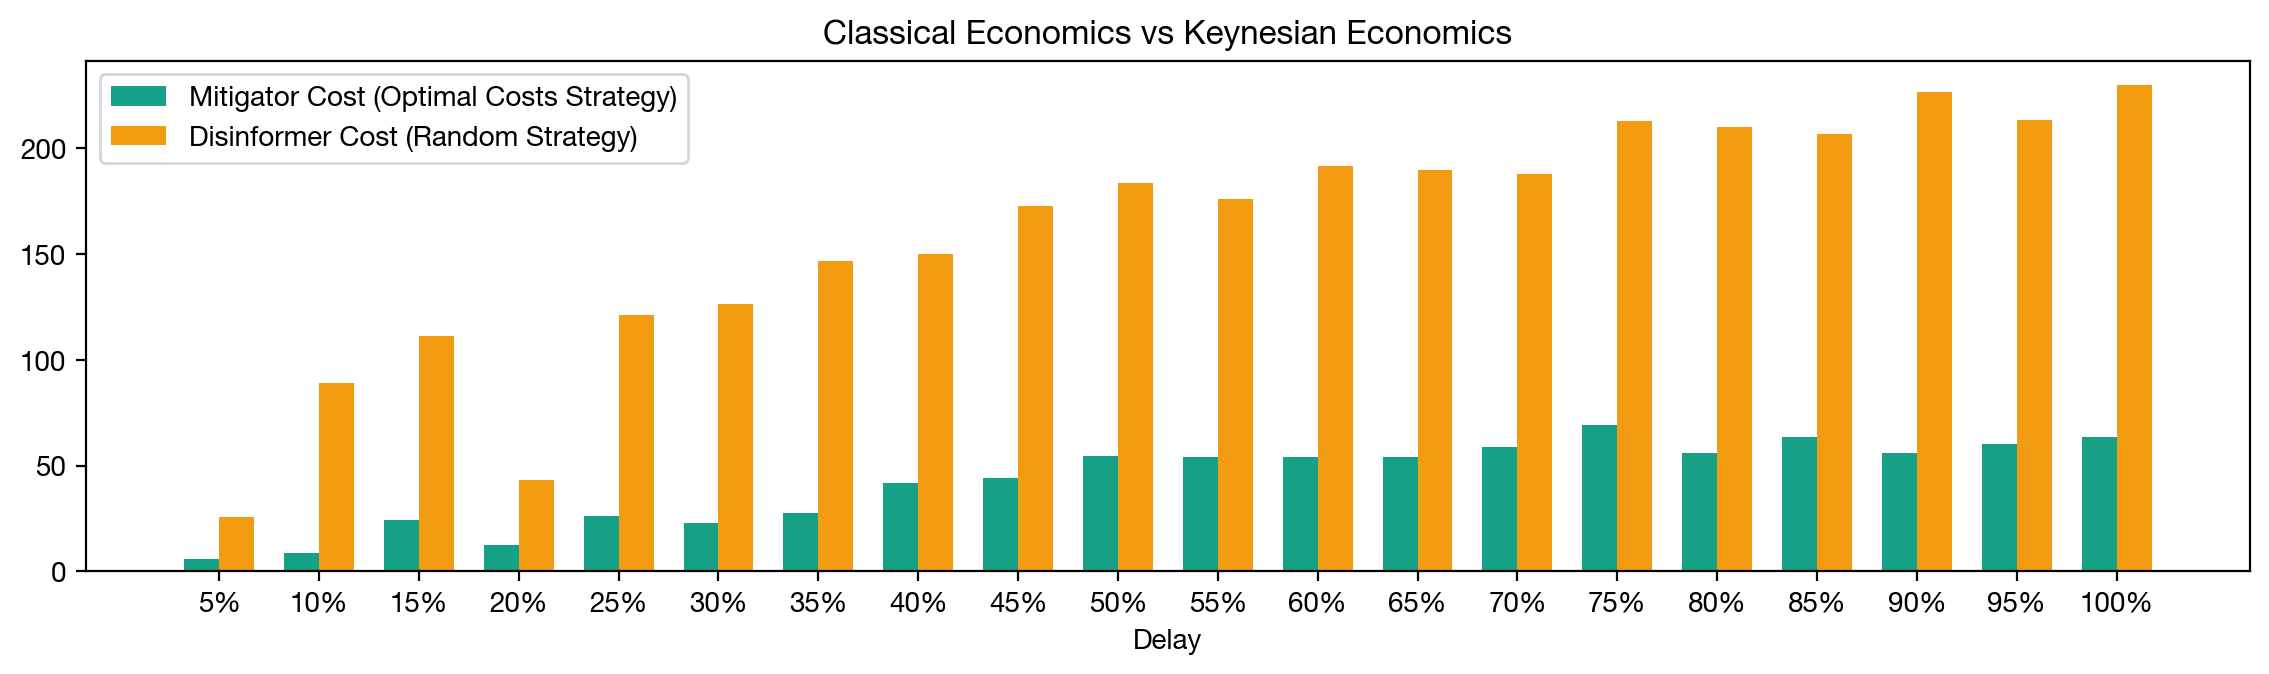

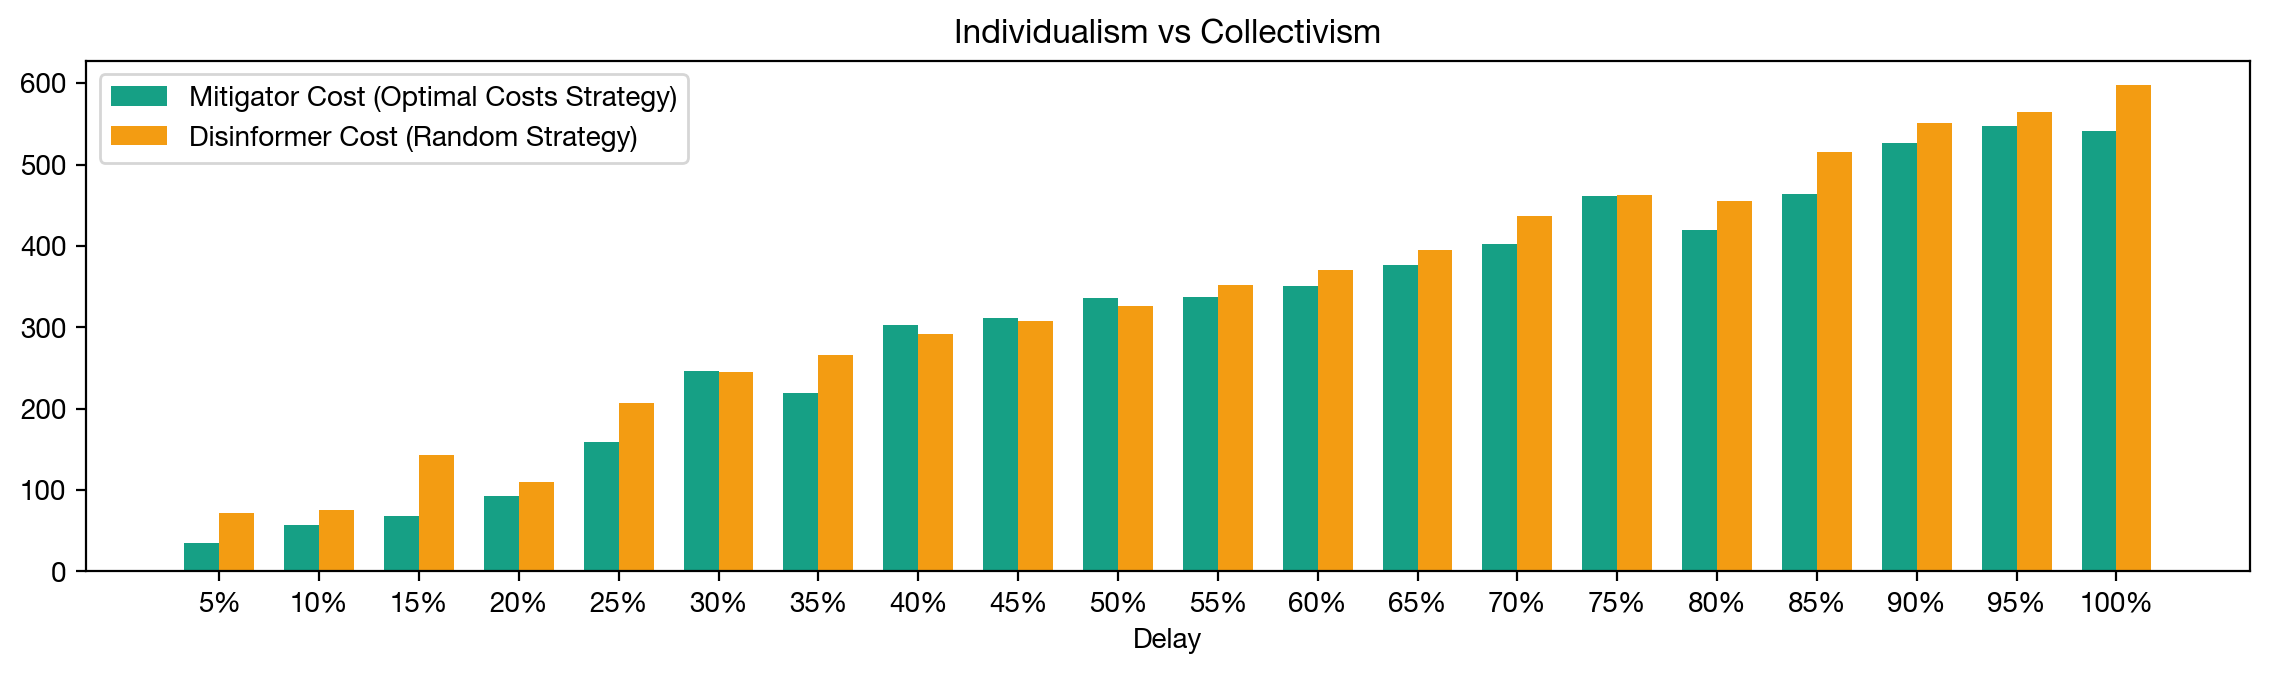

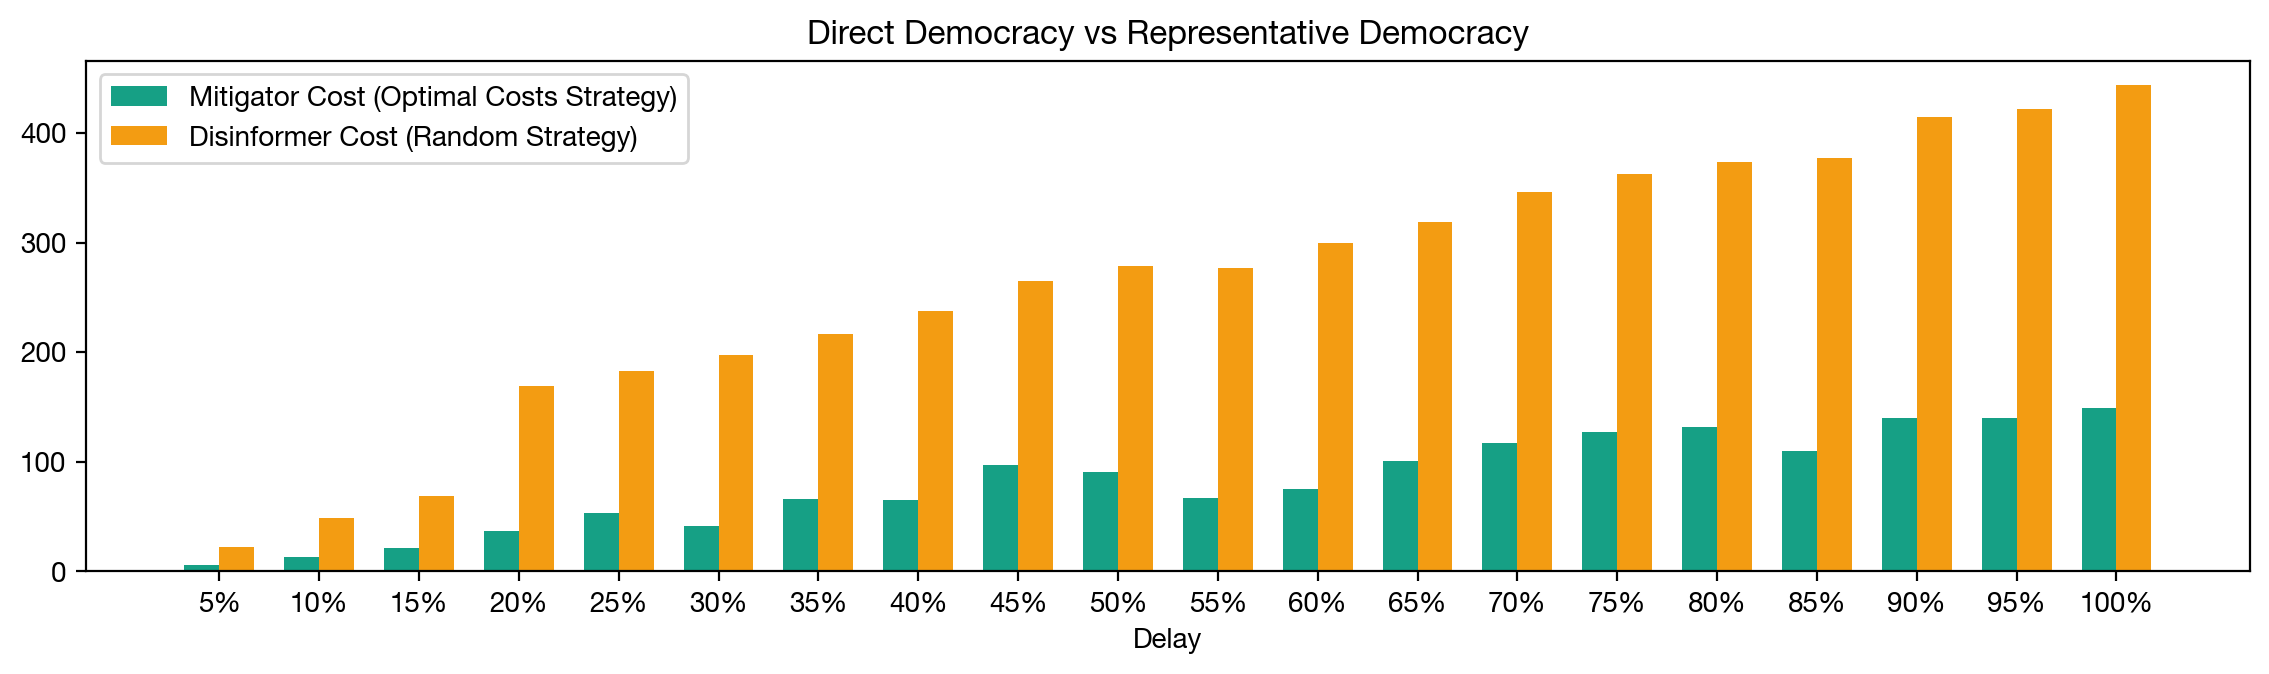

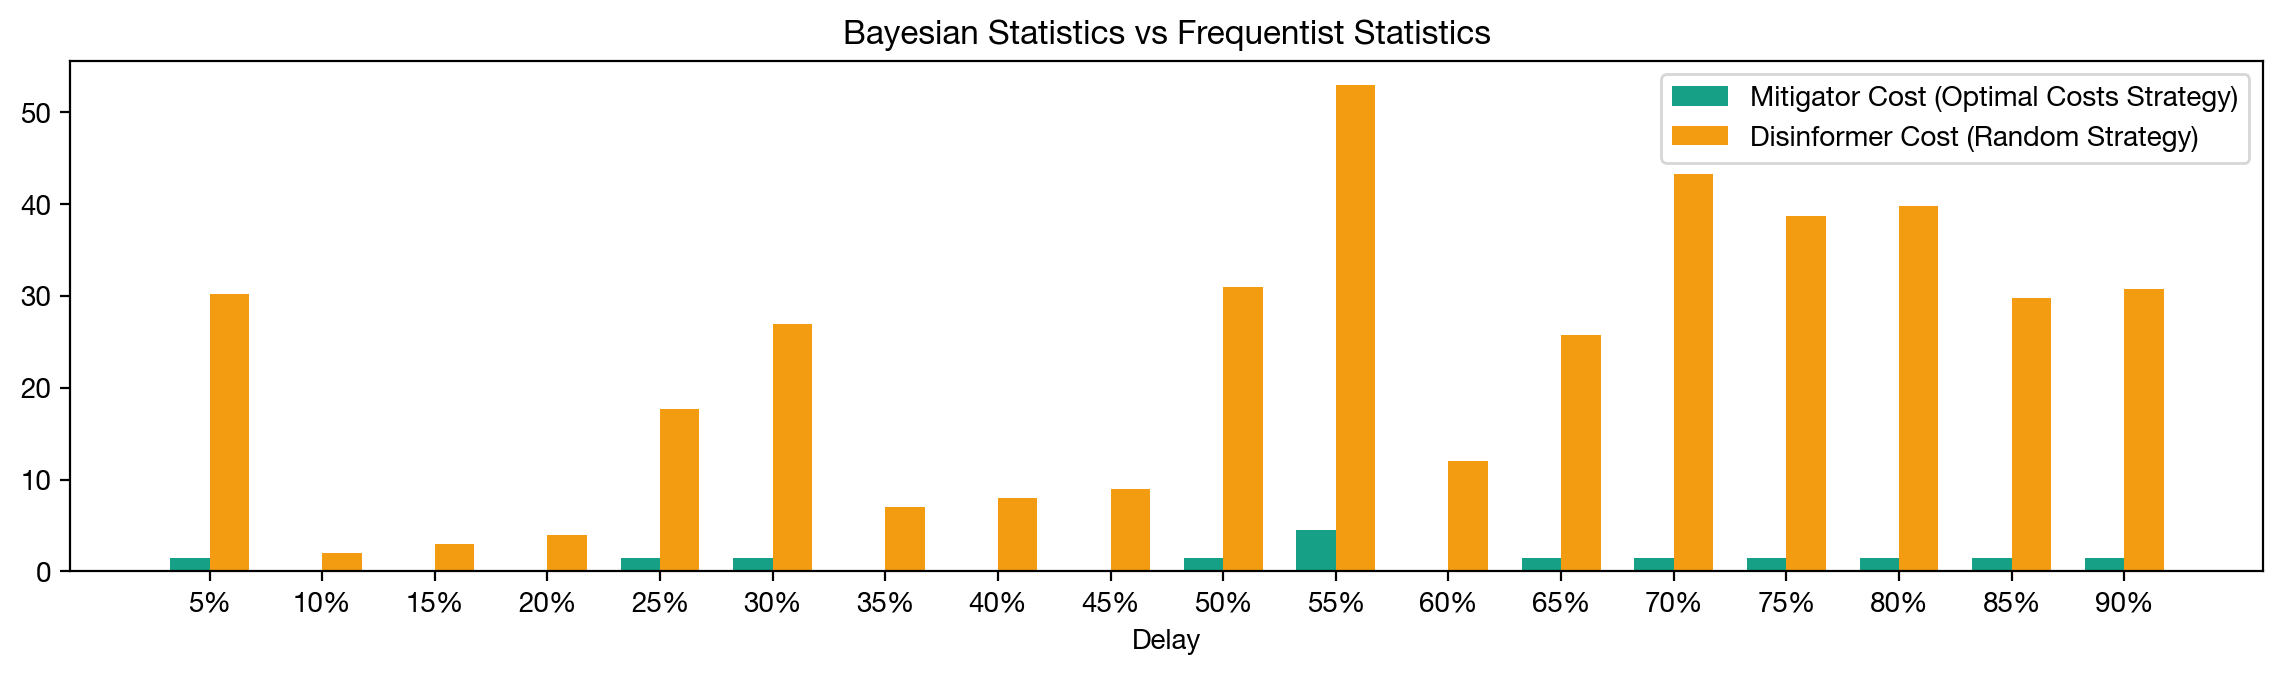

In [90]:
def generate_bar_plots(results_per_delay, topic, mitigator_label, disinformer_label, config):
    delays_steps = list(filter(lambda x: x < delayed_response_steps, results_per_delay.keys()))
    costs = {group: [
          sum(results_per_delay[s][group]) / len(results_per_delay[s][group]) for s in delays_steps
          ] for group in ['mit', 'dis']}

    # Width of a bar
    bar_width = 0.35  

    # Plot for costs
    fig, ax = plt.subplots()
    ax.set_xlabel('Delay')

    # Creating bars for each group at each delay step
    mit_bars = ax.bar(
      [x - bar_width/2 for x in range(len(delays_steps))], 
      costs['mit'], 
      width=bar_width, 
      color=main_config["groups_colors"]['mit'], 
      label='Mitigator Cost (Optimal Costs Strategy)'
    )
    dis_bars = ax.bar(
      [x + bar_width/2 for x in range(len(delays_steps))], 
      costs['dis'], 
      width=bar_width, 
      color=main_config["groups_colors"]['dis'], 
      label='Disinformer Cost (Random Strategy)'
    )

    ax.set_xticks(range(len(delays_steps)))
    ax.set_xticklabels(list(map(lambda x: f'{round((100 / delayed_response_steps) * (x + 1))}%', delays_steps)))
    ax.legend()
    fig.tight_layout()
    fig.set_size_inches(12, 3)

    # Set title
    ax.set_title(topic)


    plt.show()


for topic in datavoids_per_topic.keys():
  mitigator_label = datavoids_per_topic[topic]['mitigator']
  disinformer_label = datavoids_per_topic[topic]['disinformer']
  if topic not in results_per_delay:
     continue
  generate_bar_plots(results_per_delay[topic], topic, mitigator_label, disinformer_label, config)